In [1]:
import core.vem as vem
import numpy as np
import matplotlib.pyplot as plt

# Define the load function
def f(c):
    return -np.sin(np.pi*c[0])*np.sin(np.pi*c[1])

# Generate a structured mesh on the unit square
def unit_square_mesh(nx, ny):
    hx = 1.0 / (nx - 1)
    hy = 1.0 / (ny - 1)
    nodes = np.array([[i*hx, j*hy] for j in range(ny) for i in range(nx)])
    elements = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n0 = i + j*nx
            n1 = n0 + 1
            n2 = n0 + nx
            n3 = n2 + 1
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return nodes, np.array(elements)

# Function to get boundary node indices
def get_boundary_nodes(nodes):
    tol = 1e-12
    boundary_indices = np.where((np.abs(nodes[:, 0]) < tol) | (np.abs(nodes[:, 0] - 1) < tol) |
                                (np.abs(nodes[:, 1]) < tol) | (np.abs(nodes[:, 1] - 1) < tol))[0]
    return boundary_indices

# Parameters
nx = 31  # Number of nodes in x direction
ny = 31  # Number of nodes in y direction
nodes, elements = unit_square_mesh(nx, ny)
supp = get_boundary_nodes(nodes)


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

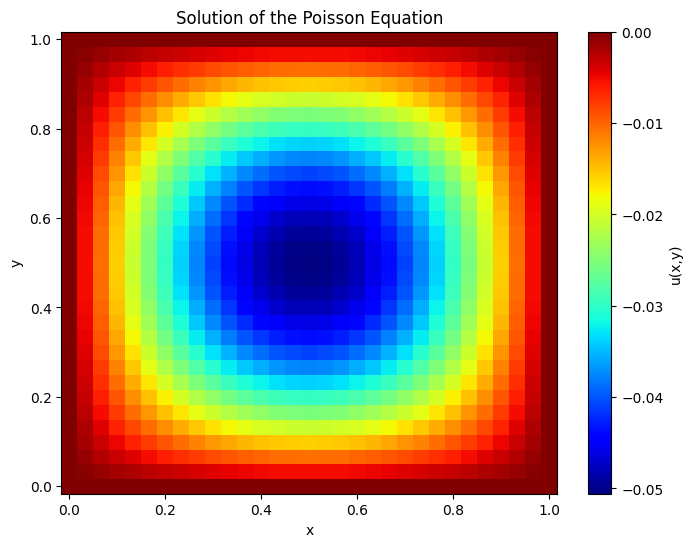

In [2]:
K = vem.buildGlobalPoisson(nodes, elements)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

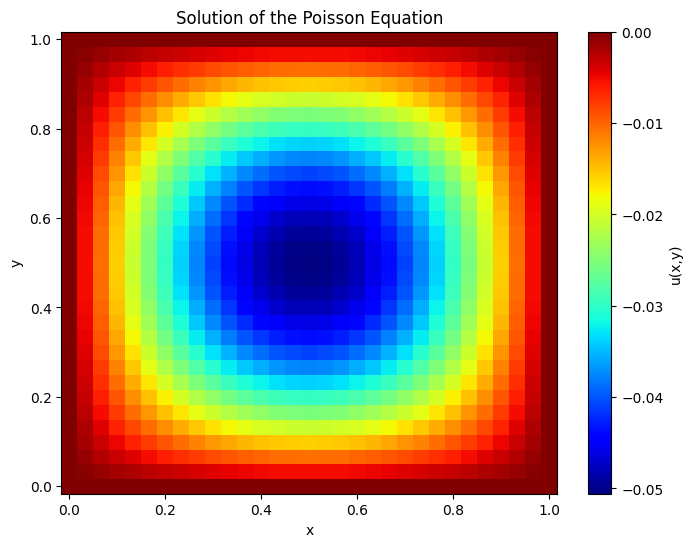

In [3]:
# not using Ks
K = vem.buildGlobalPoisson(nodes, elements, use_stabilization=False)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

# Define a neural network to approximate an n x n matrix
class MatrixApproximator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
input_dim = nx * ny  # Input dimension corresponding to each element in the matrix
output_dim = nx * ny  # Output dimension corresponding to each element in the matrix

model = MatrixApproximator(input_dim, output_dim)
loss = compute_loss(torch.tensor(K), torch.tensor(uh), torch.tensor(F))

In [5]:
# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh = np.linalg.solve(K,f)
print(uh)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
epochs = 1000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(torch.tensor(K), uh, torch.tensor(f))
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [294]:
threshold = 1e-6

# Convert K and f to tensors if they are not already
K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)
uh = model(nodes)

print(uh)

optimizer.zero_grad()
loss = compute_loss(K, uh, f) + compute_boundary_loss(uh, supp)
loss.backward()
optimizer.step()

print(loss.item())

tensor([-1.8664e-06,  3.3136e-06,  4.1500e-06,  1.3343e-02,  5.4490e-04,
        -6.5258e-03,  1.3252e-02, -1.2227e-03, -4.5127e-03, -4.8606e-06,
         4.6082e-06,  4.0308e-06], grad_fn=<ViewBackward0>)
1591633.25


/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_84936/2668017364.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_84936/2668017364.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = torch.tensor(f, dtype=torch.float32, requires_grad=True)


In [21]:
uh

tensor([ 0.0125,  0.0982,  0.0564, -0.2762, -0.0584, -0.0330,  0.1792, -0.0095,
         0.1935, -0.0567, -0.1271,  0.0788], grad_fn=<ViewBackward0>)